# Analyze the HNN pixel task

In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython import display
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import os, sys
parent_dir = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_dir)

from data import get_dataset
from nn_models import MLPAutoencoder, MLP
from hnn import HNN, HNNBaseline, PixelHNN
from utils import make_gif, L2_loss, integrate_model

## Set some notebook constants

In [63]:
DPI = 120
LINE_SEGMENTS = 20
LINE_WIDTH = 2
FORMAT = 'png'

def get_args():
    return {'input_dim': 784,
         'hidden_dim': 200,
         'latent_dim': 2,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'print_every': 200,
         'num_frames': 400,
         'name': 'pendulum',
         'seed': 0,
         'save_dir': '.',
         'fig_dir': '../figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Make a GIF from frames in the dataset

Successfully loaded data from ./pendulum-pixels-dataset.pkl


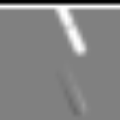

In [64]:
args = ObjectView(get_args())

# load dataset
data = get_dataset(args.name, args.save_dir, verbose=False)
side = data['meta']['side']
trials = data['meta']['trials']
timesteps = data['meta']['timesteps']

frames = data['pixels'].reshape(-1, side, side)[:args.num_frames]
name = '{}-dataset'.format(args.name)
gifname = make_gif(frames, args.fig_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

## Construct models

In [65]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)

autoencoder = MLPAutoencoder(args.input_dim, args.hidden_dim,
                             args.latent_dim, nonlinearity='relu')
model = PixelHNN(args.latent_dim, args.hidden_dim, autoencoder,
                 nonlinearity=args.nonlinearity, baseline=False)
path = "{}/pendulum-pixels-hnn.tar".format(args.save_dir)
model.load_state_dict(torch.load(path))

## How good is the autoencoder?

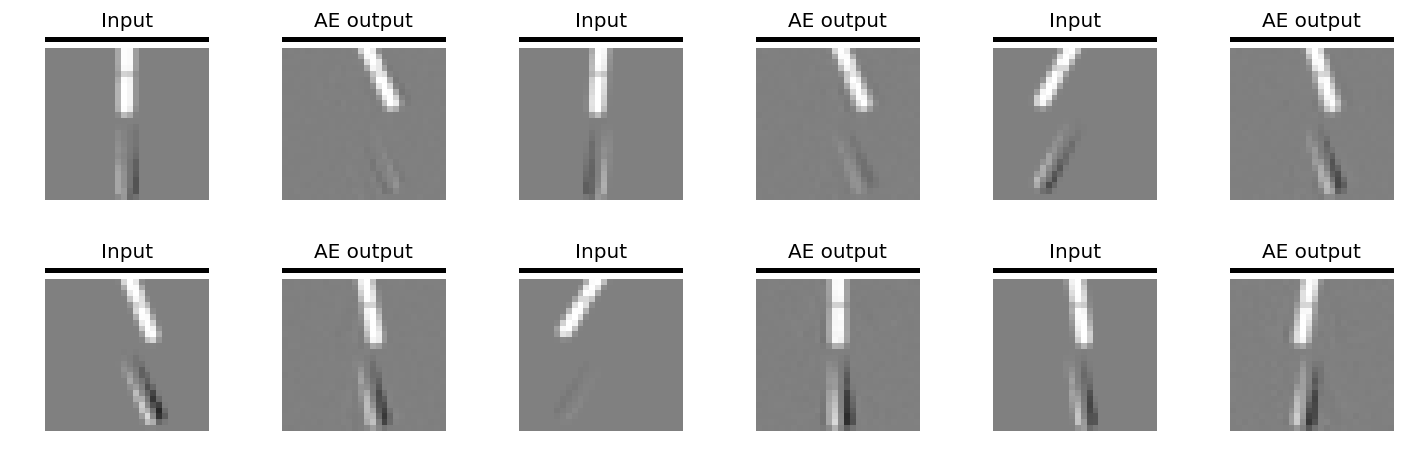

In [66]:
rows, cols = 2, 3
fig = plt.figure(figsize=[2*2*cols, 2*rows], dpi=DPI)

x = torch.tensor( data['pixels'], dtype=torch.float32)
x_next = torch.tensor( data['next_pixels'], dtype=torch.float32)

ixs = torch.randperm(trials*timesteps-3*trials)[:2*rows*cols]
bx, bx_next = x[ixs], x_next[ixs]
bx_hat_next = model(x)

for r in range(rows):
  for c in range(cols):
    ix = r*2*cols + 2*c
    
    plt.subplot(rows, 2*cols, ix + 1)
    im = bx_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
    
    
    plt.subplot(rows, 2*cols, ix + 2)
    im = bx_hat_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
    
plt.tight_layout() ; plt.show()
fig.savefig('{}/autoencoder-hnn.{}'.format(args.fig_dir, FORMAT))

## How does the latent space look?

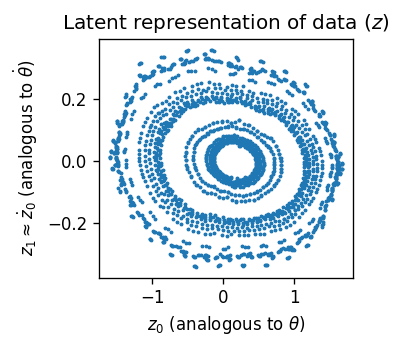

In [67]:
fig = plt.figure(figsize=(3.25, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 1, 1, frameon=True)
latents = model.encode(x).detach().numpy()
plt.plot(latents[:,0], latents[:,1], '*', markersize=2)

ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("Latent representation of data ($z$)")

plt.tight_layout() ; plt.show()
fig.savefig('{}/latents-hnn.{}'.format(args.fig_dir, FORMAT))

## Compare to actual angular quantities

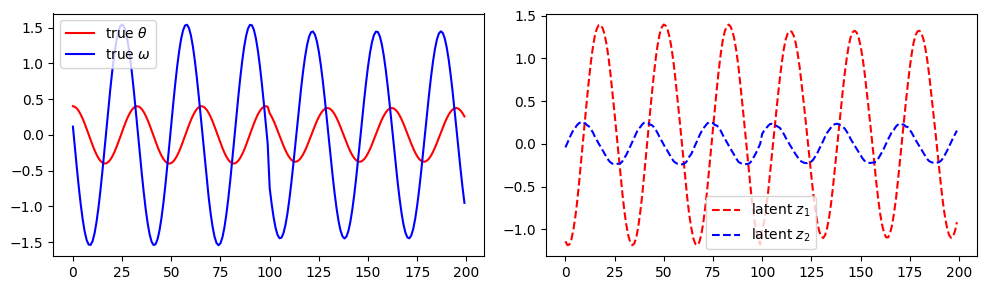

In [68]:
k = 200
fig = plt.figure(figsize=[10,3], dpi=100)
plt.subplot(1,2,1)
plt.plot(data['coords'][:k,0], "r-", label='true $\\theta$')    # ground truth coordinates (theta and omega)
plt.plot(data['coords'][:k,1], "b-", label='true $\omega$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(latents[:k,0], "r--", label='latent $z_1$')   # learned by autoencoder (in an unsupervised manner)
plt.plot(latents[:k,1], "b--", label='latent $z_2$')
plt.legend()

plt.tight_layout() ; plt.show()

## Plot phase space

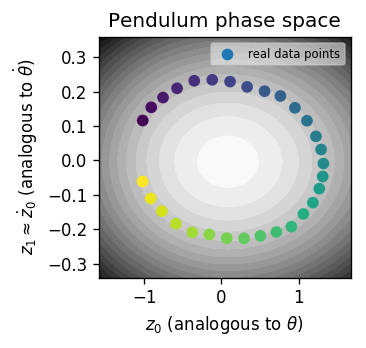

In [69]:
# set domain
gs = 50
xmin, xmax = latents[:,0].min(), latents[:,0].max()
vmin, vmax = latents[:,1].min(), latents[:,1].max()

# feed through model
gX, gV = np.meshgrid(np.linspace(xmin, xmax, gs), np.linspace(vmin, vmax, gs))
np_mesh_inputs = np.stack([gX.flatten(), gV.flatten()]).T
mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)

# get scalar fields
F1, F2 = model.hnn(mesh_inputs)
np_F1, np_F2 = F1.data.numpy().reshape(gs,gs), F2.data.numpy().reshape(gs,gs)

# plot phase space
fig = plt.figure(figsize=(3.15, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("Pendulum phase space")

# plot data points
k = 30 ; t = 100
c = np.linspace(0, 10, k)
plt.scatter(latents[:,0][t:t+k], latents[:,1][t:t+k], c=c, cmap='viridis', label='real data points')

plt.legend(fancybox=True, framealpha=.5, fontsize=7)
plt.tight_layout() ; plt.show()
fig.savefig('{}/learned-phase-space.{}'.format(args.fig_dir, FORMAT))

## Plot total energy

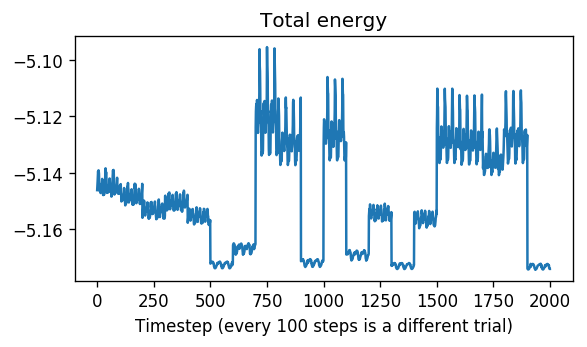

In [70]:
fig = plt.figure(figsize=[5,3], dpi=DPI)

z_values = model.encode(x)
F1, F2 = model.hnn(z_values)
energy = F2.detach().numpy()
plt.plot(energy)
plt.title("Total energy")
plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))
plt.tight_layout() ; plt.show()
fig.savefig('{}/total-energy.{}'.format(args.fig_dir, FORMAT))

## Integrate HNN in latent space

In [71]:
def conserve_energy_fun(t, np_x):
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    x = x.view(1, np.size(np_x))
    dx = model.time_derivative(x).data.numpy().reshape(-1)
    return dx
    
def add_energy_fun(t, np_x):
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    x = x.view(1, np.size(np_x)) # batch size of 1
    
    _, F2 = model.hnn(x)
    dx = torch.autograd.grad(F2.sum(), x, create_graph=True)[0]
        
    np_dx = dx.data.numpy().reshape(-1)
    return np_dx

In [72]:
point_density = 20
t_evals = lambda t_span: int( (t_span[1] - t_span[0])*point_density )

t_span1 = [0,50]
y0 = np.asarray([.5, 0])
kwargs = {'t_eval': np.linspace(t_span1[0], t_span1[1], t_evals(t_span1))}
path1 = integrate_model(model, t_span1, y0, fun=conserve_energy_fun, **kwargs)

t_span2 = [0,3.7]
y0 = path1['y'][:,-1]
kwargs = {'t_eval': np.linspace(t_span2[0], t_span2[1], t_evals(t_span2)), 'rtol': 1e-12}
path2 = integrate_model(model, t_span2, y0, fun=add_energy_fun, **kwargs)

t_span3 = [0,50]
y0 = path2['y'][:,-1]
kwargs = {'t_eval': np.linspace(t_span3[0], t_span3[1], t_evals(t_span3))}
path3 = integrate_model(model, t_span3, y0, fun=conserve_energy_fun, **kwargs)

y = np.concatenate([path1['y'], path2['y'], path3['y']], axis=-1).T

# y.shape[0] % LINE_SEGMENTS should be 0
terminal_ix = LINE_SEGMENTS * (y.shape[0]//LINE_SEGMENTS)
y = y[:terminal_ix]

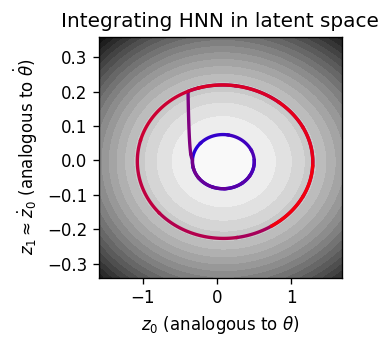

In [73]:
fig = plt.figure(figsize=(3.15, 3), facecolor='white', dpi=DPI)

ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
for i, l in enumerate(np.split(y, LINE_SEGMENTS)):
    
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Integrating HNN in latent space")

ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")

plt.tight_layout() ; plt.show()
fig.savefig('{}/integrate-latent-hnn.{}'.format(args.fig_dir, FORMAT))

## Project back into pixel space and render

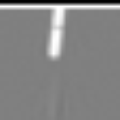

In [74]:
simulated_latents = torch.tensor( y, dtype=torch.float32)
simulated_pixels = model.decode(simulated_latents)
sim_frames = simulated_pixels.data.numpy().reshape(-1,side,side)

name = '{}-sim-hnn'.format(args.name)
gifname = make_gif(sim_frames[::25], args.fig_dir, name=name, duration=1e-1, pixels=[120,120])
display.Image(filename=gifname, width=200)